# Bayesian Logistic Regression

**DISCLAIMER**: I should mention that this is the first time I program in Julia, so for any Julia pros out there: please bear with me! Happy to hear your suggestions/comments.

## Preliminaries

We will need a couple of standard Julia libraries, which are loaded below:

In [1]:
using CSV;
using DataFrames;
using LinearAlgebra;

The toy data set and ground truth were generated in R. To inspect the code for this check out the [R Markdown document](index.html) that generates the blog post. Here we will start straight from the data set:

In [2]:
df = CSV.read("data/cats_dogs.csv", DataFrame);
rename!(df, [:V1, :V2] .=> [:x_1, :x_2]);

For plotting we will use the R package `ggplot2` which can be readily integrated into Julia (just like many other R packages, see for example [here](https://avt.im/blog/2018/03/23/R-packages-ggplot-in-julia#fn:rcall)).

In [3]:
using RCall
@rlibrary ggplot2
@rlibrary ggimage
@rlibrary emojifont
@rlibrary viridis
p = ggplot() +
  theme_bw();

Below follows some preprocessing and the initialization of the zero-mean prior:

In [4]:
y = df[:,:y];
N = length(y);
X = Matrix(df[:,Not(:y)]);
X = [ones(N) X]; # add for constant
d = size(X)[2]; # number of features
w_0 = zeros(d); # zero-mean prior

Finally, the cell below can be used to source all the necessary functions directly. The first final two lines are commented out since we will go through them bit by bit below.

In [5]:
include("julia/utils.jl");
#include("julia/bayes_logreg.jl"); 
#include("julia/optimization.jl");

## Model, loss and derivatives

*DISCLAIMER:* The Julia code presented in this section is in some places loosely insipired by the python library [bayes_logistic](https://bayes-logistic.readthedocs.io/en/latest/index.html). 

The cell below generates the sigmoid/logistic function:

In [6]:
# Sigmoid function:
function sigmoid(w,X)
    trunc = 8.0 # truncation to avoid numerical over/underflow
    if !isa(X, Matrix)
        if length(size(X))>1
            X = X'
        end
        z = X'w
    else
        z = X*w
    end
    z = clamp.(z,-trunc,trunc)
    p = exp.(z)
    p = p ./ (1 .+ p)
    return p
end

sigmoid (generic function with 1 method)

The loss function and its derivatives can be implemented as follows:

In [7]:
# Negative log likelihood
function 𝓁(w,w_0,H_0,X,y)
    N = length(y)
    D = size(X)[2]
    μ = sigmoid(w,X)
    Δw = w-w_0
    return - ∑( y[n] * log(μ[n]) + (1-y[n]) * log(1-μ[n]) for n=1:N) + 1/2 * Δw'H_0*Δw
end

# Gradient:
function ∇𝓁(w,w_0,H_0,X,y)
    N = length(y)
    μ = sigmoid(w,X)
    Δw = w-w_0
    g = ∑((μ[n]-y[n]) * X[n,:] for n=1:N)
    return g + H_0*Δw
end

# Hessian:
function ∇∇𝓁(w,w_0,H_0,X,y)
    N = length(y)
    μ = sigmoid(w,X)
    H = ∑(μ[n] * (1-μ[n]) * X[n,:] * X[n,:]' for n=1:N)
    return H + H_0
end

∇∇𝓁 (generic function with 1 method)

## Optimization

The code below implements Newton's method. The Arminjo backtracking method is used to determine the optimal step length in each iteration.

In [8]:
# Newton's Method
function arminjo(𝓁, g_t, θ_t, d_t, args, ρ, c=1e-4)
    𝓁(θ_t .+ ρ .* d_t, args...) <= 𝓁(θ_t, args...) .+ c .* ρ .* d_t'g_t
end

function newton(𝓁, θ, ∇𝓁, ∇∇𝓁, args; max_iter=100, τ=1e-5)
    # Intialize:
    converged = false # termination state
    t = 1 # iteration count
    θ_t = θ # initial parameters
    # Descent:
    while !converged && t<max_iter 
        global g_t = ∇𝓁(θ_t, args...) # gradient
        global H_t = ∇∇𝓁(θ_t, args...) # hessian
        converged = all(abs.(g_t) .< τ) && isposdef(H_t) # check first-order condition
        # If not converged, descend:
        if !converged
            d_t = -inv(H_t)*g_t # descent direction
            # Line search:
            ρ_t = 1.0 # initialize at 1.0
            count = 1
            while !arminjo(𝓁, g_t, θ_t, d_t, args, ρ_t) 
                ρ_t /= 2
            end
            θ_t = θ_t .+ ρ_t .* d_t # update parameters
        end
        t += 1
    end
    # Output:
    return θ_t, H_t 
end

newton (generic function with 1 method)

## Bringing things together

The cell below generates the main wrapper function `bayes_logreg` that we will use below to run the regression. As its output it provides an instance of the `BayesLogreg` structure (a *class* in Python/R). What follows are a couple of methods that can be used on that structure.

In [9]:
# Main function:
struct BayesLogreg
    μ::Vector{Float64}
    Σ::Matrix{Float64}
end
function bayes_logreg(X,y,w_0,H_0,𝓁,∇𝓁,∇∇𝓁,optim_options...)
    # Model:
    w_map, H_map = newton(𝓁, w_0, ∇𝓁, ∇∇𝓁, (w_0=w_0, H_0=H_0, X=X, y=y), optim_options...) # fit the model (find mode of posterior distribution)
    Σ_map = inv(H_map) # inverse Hessian at the mode
    Σ_map = Symmetric(Σ_map) # to ensure matrix is Hermitian (i.e. avoid rounding issues)
    # Output:
    mod = BayesLogreg(w_map, Σ_map)
    return mod
end

# Methods:
μ(mod::BayesLogreg) = mod.μ
Σ(mod::BayesLogreg) = mod.Σ
using Distributions
# Sampling from posterior distribution:
function sample_posterior(mod::BayesLogreg, n)
    rand(MvNormal(mod.μ, mod.Σ),n)
end
# Posterior predictions:
function posterior_predictive(mod::BayesLogreg, X)
    μ = mod.μ # MAP mean vector
    Σ = mod.Σ # MAP covariance matrix
    # Inner product:
    if !isa(X, Matrix)
        if length(size(X))>1
            X = X'
        end
        z = X'μ
    else
        z = X*μ
    end
    # Probit approximation
    v = [X[n,:]'Σ*X[n,:] for n=1:size(X)[1]]
    κ = 1 ./ sqrt.(1 .+ π/8 .* v) 
    z = κ .* z
    # Truncation to avoid numerical over/underflow:
    trunc = 8.0 
    z = clamp.(z,-trunc,trunc)
    p = exp.(z)
    p = p ./ (1 .+ p)
    return p
end

posterior_predictive (generic function with 1 method)

## Running the model

Setting $\sigma=\infty$ we impose maximal uncertainty around our prior beliefs. In other words, prior beliefs are non-informative and our posterior will correspond to the unconstrained maximum likelihood estimate. Below we compute that estimate and store it for later use:

In [10]:
H_0 = UniformScaling(1/1e10);
mle = bayes_logreg(X,y,w_0,H_0,𝓁,∇𝓁,∇∇𝓁);

## Posterior 

Now let's take a look at the estimates of the posterior. We will keep vary the uncertainty around our prior to see the effect this has on the posterior.

In [11]:
step = 0.05;
range = 2;
W = expandgrid(-range:step:range,-range:step:range);
N_grid = size(W)[1];
σ = [1e-10, 1, 100, 1e10]; # prior uncertainty

In [12]:
estimates = DataFrame()
for i=1:length(σ)
    H_0 = UniformScaling(1/(σ[i]^2));
    model = bayes_logreg(X,y,w_0,H_0,𝓁,∇𝓁,∇∇𝓁);
    posterior = -1 .* [logpdf(MvNormal(model.μ,model.Σ),vcat(model.μ[1],W[n,:])) for n=1:N_grid]
    estimate = DataFrame(hcat(posterior,W), :auto);
    insertcols!(estimate, 4, :noise => σ[i])
    estimates = vcat(estimates, estimate)
end 
transform!(groupby(estimates, :noise), :x1 => (x -> x ./ maximum(x)) => :x1); # rescale for visualization

In [13]:
points = DataFrame(x=mle.μ[2],y=mle.μ[3]);

The plot below shows the resulting posterior distribution for $\mathbf{w}_2$ and $\mathbf{w}_3$. The constant $\mathbf{w}_1$ is held constant at the mode ($\hat{\mathbf{w}}_1$). The red dot indicate the MLE estimate. 

Note how for the choice of $\sigma\rightarrow 0$ the posterior is equal to the prior. This is intuitive since we have imposed that we have no uncertainty around our prior beliefs and hence no amount of new evidence can move us in any direction. Conversely, for $\sigma \rightarrow \infty$ the posterior distribution corresponds to the MLE posterior centered around the red dot.

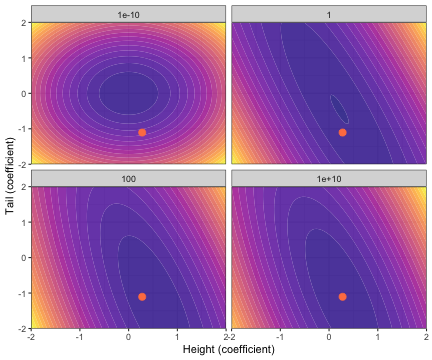

RObject{VecSxp}


In [14]:
p + 
  geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
  geom_point(data=points, aes(x=:x, y=:y), size=3, colour="coral") +
  scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
  scale_fill_viridis(option="C",discrete=true) +
  guides(fill="none") +
  facet_wrap(R"~noise") +
  labs(x="Height (coefficient)", y="Tail (coefficient)") # |>
  # p -> ggsave("www/posterior.png", plot = p, width=5, height=5)

## Posterior Predictive

Finally, we repeat the exercise above, but this time we will look at the posterior predictive distribution.

In [15]:
step = 1;
expand = 20;
W = expandgrid((minimum(df.x_1)-expand):step:(maximum(df.x_1)+expand),(minimum(df.x_2)-expand):step:(maximum(df.x_2)+expand));
N_grid = size(W)[1];
σ = [1e-10, 1, 100, 1e10]; # prior uncertainty

In [16]:
features = DataFrame()
estimates = DataFrame()
for i=1:length(σ)
    H_0 = UniformScaling(1/(σ[i]^2));
    model = bayes_logreg(X,y,w_0,H_0,𝓁,∇𝓁,∇∇𝓁);
    w_map = model.μ;
    y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
    estimate = DataFrame(hcat(y_probit,W), :auto);
    insertcols!(estimate, 4, :noise => σ[i])
    estimates = vcat(estimates, estimate)
    feature = copy(df)
    insertcols!(feature, :noise => σ[i])
    features = vcat(features, feature)
    end 
# Adding emojis 
transform!(features, :y => (x -> ifelse.(x.==0,"www/cat.png","www/dog.png"))  => :emoji);

Since for $\sigma\rightarrow 0$ the posterior is completely dominated by the prior we have $p(y=1|\mathbf{x},\hat{\mathbf{w}})=0.5$ everywhere. As we gradually increase uncertainty around our prior the predictive posterior depends more and more on the data $\mathcal{D}$: uncertainty around predicted labels is high in regions that are not populated by samples $(y_n, \mathbf{x}_n)$. Not surprisingly, this effect is strongest for the MLE ($\sigma\rightarrow \infty$) and indicative of overfitting.

In [ ]:
p + 
  geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
  geom_image(data=features, aes(x=:x_1, y=:x_2, image=:emoji), size=0.1) +
  guides(fill="none") +
  scale_fill_viridis(option="C",discrete=true) +
  scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
  facet_wrap(R"~noise") +
  labs(x="Height", y="Tail") # |>
  # p -> ggsave("www/predictive.png", plot = p, width=5, height=5)
